<a href="https://colab.research.google.com/github/drdww/OPIM5641/blob/main/Module4/M4_2/2_MaximumCovering_Firehouse_dw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integer Programming: Maximum Set Covering (Firehouse)
**OPIM 5641: Business Decision Modeling - University of Connecticut**

Related Readings:
* `Powell`: Chapter 11 (Integer Optimization)
* https://en.wikipedia.org/wiki/Set_cover_problem

-------------------------------------------------------


Let's extend what we learned to a more involved example. Let's force the model to only install up to TWO firehouses and cover the most people possible. Requires us to embrace activation variables (where you should build the firehouse) and coverage variables (which districts/neighborhoods are covered).

# Import modules

In [ ]:
# import modules

%matplotlib inline
from pylab import *

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

from pyomo.environ import *

# Problem Description

Our original objective is to locate fire stations so that each district has a fire station in it, or next to it. While doing so, we want to minimize the number of fire stations needed (which is a monster! more clearly laid out in the constraints, but sometimes data comes this way).


First, we have our traditional 'adjacency' matrix for a set covering problem.

Site|S1|S2|S3|S4|S5|S6|S7|S8|S9|S10|S11|S12|S13|S14| S15|S16     
--- |---|--- | --- | --- |--- | --- |--- | --- |---|--- | --- | --- |--- | --- |--- | --- |
District D1  |1|1|0|1|1|0|0|0|0|0|0|0|0|0|0|0|
District D2  |1|1|1|0|1|1|0|0|0|0|0|0|0|0|0|0|
District D3  |0|1|1|0|0|1|1|0|0|0|0|0|0|0|0|0|
District D4  |1|0|0|1|0|0|0|1|0|1|1|0|0|0|0|0|
District D5  |1|1|0|1|1|1|0|1|0|0|0|0|0|0|0|0|
District D6  |0|1|1|0|1|1|1|1|1|0|0|0|0|0|0|0|
District D7  |0|0|1|0|0|1|1|0|1|0|0|0|1|0|0|0|
District D8  |0|0|0|1|1|1|0|1|1|0|1|1|0|0|0|0|
District D9  |0|0|0|0|0|1|1|1|1|0|0|1|1|0|0|0|
District D10 |0|0|0|1|0|0|0|0|0|1|1|0|0|1|0|0|
District D11 |0|0|0|1|0|0|0|1|0|1|1|1|0|1|0|0|
District D12 |0|0|0|0|0|0|0|1|1|0|1|1|1|0|1|0|
District D13 |0|0|0|0|0|0|1|0|1|0|0|1|1|0|1|1|
District D14 |0|0|0|0|0|0|0|0|0|1|1|0|0|1|1|0|
District D15 |0|0|0|0|0|0|0|0|0|0|0|1|1|1|1|1|
District D16 |0|0|0|0|0|0|0|0|0|0|0|0|1|0|1|1|



* Consider now that **each location has a weight** proportional to its importance (e.g., number of houses in the location); you can also interpret this weight as demand

* Goal: place **up to $2$ stations** so as to maximize the covered demand

* Limit on the number of facilities is a cardinality constraint.

* The demand in each location is as follows (you can imagine this as another entry in the table):

location | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16
--- | --- | --- | -- | -- | -- | -- | -- | -- | -- | -- | --| -- | -- | -- | -- | --
demand | 10 | 13 | 12 | 20 | 31 | 45 | 60 | 12 | 56 | 8 | 51 | 23 | 17 | 10 | 35 | 22

Here's the layout of the locations (isn't it nice to have a graphic?!):

<center>

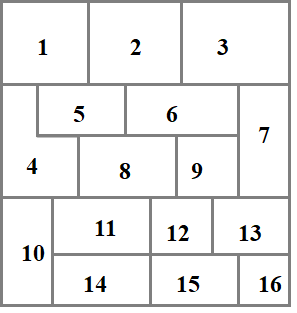

</center>

## Activation vs. Coverage

* Be careful with two different concepts going on in this problem: activation vs coverage
  * **Activation** ($x$ variables): installing a fire station in a district
  * **Coverage** ($y$ variables): having a fire station nearby
  * One district may be covered by more than one fire station, but the demand should be counted only once!

# Problem Formulation

**Define the Objective Function**

$\max \sum\limits_{i = 1}^{16}d_i y_i$ `(objective function)`

where `y` is a coverage variable, indicating that a district is 'covered'. The coverage binary indicator times demand gives us our z.

**Write the Constraints**

subject to:
* $x_1 + x_2 + x_4 + x_5 \geq y_1$       `(Site 1)`
* $x_1 + x_2 + x_3 + x_5 + x_6 \geq y_2$ `(Site 2)`
* $x_2 + x_3 + x_6 + x_7 \geq y_3$  `(Site 3)`
* $x_1 + x_4 + x_5 + x_8 + x_{10} + x_{11} \geq y_4$ `(Site 4)`
* $x_1 + x_2 + x_4 + x_5 + x_6 + x_8 \geq y_5$ `(Site 5)`
* $x_2 + x_3 + x_5 + x_6 + x_8 + x_7 + x_9 \geq y_6$ `(Site 6)`
* $x_3 + x_6 + x_7 + x_9 + x_{13} \geq y_7$ `(Site 7)`
* $x_4 + x_5 + x_6 + x_8 + x_9 + x_{11} + x_{12} \geq y_8$ `(Site 8)`
* $x_6 + x_7 + x_8 + x_9 + x_{12} + x_{13} \geq y_9$ `(Site 9)`
* $x_4 + x_{10} + x_{11} + x_{14} \geq y_{10}$ `(Site 10)`
* $x_4 + x_8 + x_{10} + x_{11} + x_{12} + x_{14} \geq y_{11}$ `(Site 11)`
* $x_8 + x_9 + x_{11} + x_{12} + x_{13} + x_{15} \geq y_{12}$ `(Site 12)`
* $x_7 + x_9 + x_{12} + x_{13} + x_{15} + x_{16} \geq y_{13}$ `(Site 13)`
* $x_{10} + x_{11} + x_{14} + x_{15} \geq y_{14}$ `(Site 14)`
* $x_{12} + x_{13} + x_{14} + x_{15} + x_{16} \geq y_{15}$ `(Site 15)`
* $x_{13} + x_{15} + x_{16} \geq y_{16}$ `(Site 16)`

where `x` is an activation variable, meaning that we installed that fire station.

`Domains`
* $x_i \in \{0,1\}, i \in [16]$  `(only binary activation variables)`

`At most 2 fire stations`
* $\sum\limits_{i = 1}^{16}x_i \leq 2$

`Domains`
* $ x_i \in \{0,1\}, i \in [16]$ `activation variables`
* $ y_i \in \{0,1\}, i \in [16]$ `coverage variables`

# Simple Code
Here is a code in the style of Powell.

In [ ]:
# 1) concrete model
model = ConcreteModel()

In [ ]:
# 2) declare decision variables
# ALL OF THEM ARE BINARY VARIABLES!

# activation variables
# Activation ( x  variables): installing a fire station in a district
model.x = Var([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], domain=Binary)

x1  = model.x[1] 
x2  = model.x[2] 
x3  = model.x[3] 
x4  = model.x[4]
x5  = model.x[5] 
x6  = model.x[6]
x7  = model.x[7]
x8  = model.x[8] 
x9  = model.x[9] 
x10 = model.x[10] 
x11 = model.x[11]
x12 = model.x[12] 
x13 = model.x[13]
x14 = model.x[14]
x15 = model.x[15]
x16 = model.x[16]

# coverage variables
# Coverage ( y  variables): having a fire station nearby
model.y = Var([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], domain=Binary)

y1  = model.y[1] 
y2  = model.y[2] 
y3  = model.y[3] 
y4  = model.y[4]
y5  = model.y[5] 
y6  = model.y[6]
y7  = model.y[7]
y8  = model.y[8] 
y9  = model.y[9] 
y10 = model.y[10] 
y11 = model.y[11]
y12 = model.y[12] 
y13 = model.y[13]
y14 = model.y[14]
y15 = model.y[15]
y16 = model.y[16]


In [ ]:
# 3) objective function
model.OBJ = Objective(expr = 10*y1 + 13*y2 + 12*y3 + 20*y4 +
                            31*y5 + 45*y6 + 60*y7 + 12*y8 +
                            56*y9 + 8*y10 + 51*y11 + 23*y12 +
                            17*y13 + 10*y14 + 35*y15 + 22*y16,
                      sense = maximize)

In [ ]:
# 4) constraints - activation
# Activation ( x  variables): installing a fire station in a district
model.ConstraintY1 = Constraint(expr = x1+x2+x4+x5 >= y1)  # (Site 1)
model.ConstraintY2 = Constraint(expr = x1+x2+x3+x5+x6 >= y2)  #(Site 2)
model.ConstraintY3 = Constraint(expr = x2+x3+x6+x7 >= y3)  #(Site 3)
model.ConstraintY4 = Constraint(expr = x1+x4+x5+x8+x10+x11 >=y4)  #(Site 4)
model.ConstraintY5 = Constraint(expr = x1+x2+x4+x5+x6+x8 >= y5)  #(Site 5)
model.ConstraintY6 = Constraint(expr = x2+x3+x5+x6+x8+x7+x9 >= y6)  #(Site 6)
model.ConstraintY7 = Constraint(expr = x3+x6+x7+x9+x13 >= y7)  #(Site 7)
model.ConstraintY8 = Constraint(expr = x4+x5+x6+x8+x9+x11+x12 >= y8)  #(Site 8)
model.ConstraintY9 = Constraint(expr = x6+x7+x8+x9+x12+x13 >= y9)  #(Site 9)
model.ConstraintY10 = Constraint(expr = x4+x10+x11+x14 >= y10)  #(Site 10)
model.ConstraintY11 = Constraint(expr = x4+x8+x10+x11+x12+x14 >= y11)  #(Site 11)
model.ConstraintY12 = Constraint(expr = x8+x9+x11+x12+x13+x15 >= y12)  #(Site 12)
model.ConstraintY13 = Constraint(expr = x7+x9+x12+x13+x15+x16 >= y13)  #(Site 13)
model.ConstraintY14 = Constraint(expr = x10+x11+x14+x15 >= y14)  #(Site 14)
model.ConstraintY15 = Constraint(expr = x12+x13+x14+x15+x16 >= y15)  #(Site 15)
model.ConstraintY16 = Constraint(expr = x13+x15+x16 >= y16)  #(Site 16)

# 4) coverage constraints - max number of locations must be less than or equal to 2!
# Coverage ( y  variables): having a fire station nearby
model.Constraint_Only2 = Constraint(expr = x1 + x2 + x3 + x4 +
                            x5 + x6 + x7 + x8 +
                            x9 + x10 + x11 + x12 +
                            x13 + x14 + x15 + x16 <= 2)

In [ ]:
# solve it
SolverFactory('cbc', executable='/usr/bin/cbc').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 372.0
  Upper bound: 372.0
  Number of objectives: 1
  Number of constraints: 17
  Number of variables: 32
  Number of binary variables: 32
  Number of integer variables: 32
  Number of nonzeros: 16
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.01
  Wallclock time: 0.01
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound

And let's see which stations we picked!

In [ ]:
# 372 people covered
print(model.OBJ())

372.0


Here are the activation variables - this is where we will install the stations.

In [ ]:
# stations activated
print('Station 1:', x1())
print('Station 2:', x2())
print('Station 3:', x3())
print('Station 4:', x4())
print('Station 5:', x5())
print('Station 6:', x6())
print('Station 7:', x7())
print('Station 8:', x8())
print('Station 9:', x9())
print('Station 10:', x10())
print('Station 11:', x11())
print('Station 12:', x12())
print('Station 13:', x13())
print('Station 14:', x14())
print('Station 15:', x15())
print('Station 16:', x16())

Station 1: 0.0
Station 2: 0.0
Station 3: 0.0
Station 4: 0.0
Station 5: 0.0
Station 6: 0.0
Station 7: 0.0
Station 8: 1.0
Station 9: 0.0
Station 10: 0.0
Station 11: 0.0
Station 12: 0.0
Station 13: 1.0
Station 14: 0.0
Station 15: 0.0
Station 16: 0.0


We could install a station in District 8 and 13!

You could also highlight which districts would indeed be covered. Here aer the covering variables (these are sites that are covered.)

In [ ]:
print('Station 1:', y1())
print('Station 2:', y2())
print('Station 3:', y3())
print('Station 4:', y4())
print('Station 5:', y5())
print('Station 6:', y6())
print('Station 7:', y7())
print('Station 8:', y8())
print('Station 9:', y9())
print('Station 10:', y10())
print('Station 11:', y11())
print('Station 12:', y12())
print('Station 13:', y13())
print('Station 14:', y14())
print('Station 15:', y15())
print('Station 16:', y16())

Station 1: 0.0
Station 2: 0.0
Station 3: 0.0
Station 4: 1.0
Station 5: 1.0
Station 6: 1.0
Station 7: 1.0
Station 8: 1.0
Station 9: 1.0
Station 10: 0.0
Station 11: 1.0
Station 12: 1.0
Station 13: 1.0
Station 14: 0.0
Station 15: 1.0
Station 16: 1.0


# Advanced Code

In [ ]:
# declare the model
model = ConcreteModel()

stations = range(1,17)
demand = [0, 10, 13, 12, 20, 31, 45, 60, 12, 56, 8, 51, 23, 17, 10, 35, 22]
neighbours = [
              [], # Empty list because lists start from zero
              [1,2,4,5],
              [1,2,3,5,6],
              [2,3,6,7],
              [1,4,5,8,10,11],
              [1,2,4,5,6,8], # Site 5
              [2,3,5,6,7,8,9],
              [3,6,7,9,13],
              [4,5,6,8,9,11,12],
              [6,7,8,9,12,13],
              [4,10,11,14], # Site 10
              [4,8,10,11,12,14],
              [8,9,11,12,13,15],
              [7,9,12,13,15,16],
              [10,11,14,15],
              [12,13,14,15,16], # Site 15
              [13,15,16]
]

# declare decision variables
model.selected = Var(stations, domain=Binary)
model.covered = Var(stations, domain=Binary)

obj_expr = 0
for station in stations:
  obj_expr += demand[station]*model.covered[station]


# declare objective
model.coverage = Objective(
                      expr = obj_expr, # values come from the table
                      sense = maximize)

# declare constraints
model.constraints = ConstraintList()

# Activation variables for station coverage
for station in stations:
  neigh_expr = 0
  for neighbour in neighbours[station]:
    neigh_expr += model.selected[neighbour]
  model.constraints.add(neigh_expr >= model.covered[station])

# Bound on maximum number of selected locations
selected_expr = 0
for station in stations:
  selected_expr += model.selected[station]
model.constraints.add(selected_expr <= 2)

# show the model you've created
model.pprint()

3 Set Declarations
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   17 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
    covered_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   16 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
    selected_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   16 : {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}

2 Var Declarations
    covered : Size=16, Index=covered_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 

In [ ]:
# solve it
SolverFactory('cbc', executable='/usr/bin/cbc').solve(model).write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 372.0
  Upper bound: 372.0
  Number of objectives: 1
  Number of constraints: 17
  Number of variables: 32
  Number of binary variables: 32
  Number of integer variables: 32
  Number of nonzeros: 16
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.0
  Wallclock time: 0.0
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 

In [ ]:
# show the results
print("Number of customers benefited = ", model.coverage())
for station in stations:
  print("Station",station,":",model.selected[station]())

Number of customers benefited =  372.0
Station 1 : 0.0
Station 2 : 0.0
Station 3 : 0.0
Station 4 : 0.0
Station 5 : 0.0
Station 6 : 0.0
Station 7 : 0.0
Station 8 : 1.0
Station 9 : 0.0
Station 10 : 0.0
Station 11 : 0.0
Station 12 : 0.0
Station 13 : 1.0
Station 14 : 0.0
Station 15 : 0.0
Station 16 : 0.0
